Dataset shape after removing outliers: (24420, 29)
Dataset shape after filtering invalid 'result': (24420, 29)
Logistic Regression Accuracy: 0.45

Confusion Matrix:
 [[879 493 466]
 [395 431 414]
 [439 469 898]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.51      0.48      0.50      1838
           0       0.31      0.35      0.33      1240
           1       0.51      0.50      0.50      1806

    accuracy                           0.45      4884
   macro avg       0.44      0.44      0.44      4884
weighted avg       0.46      0.45      0.45      4884



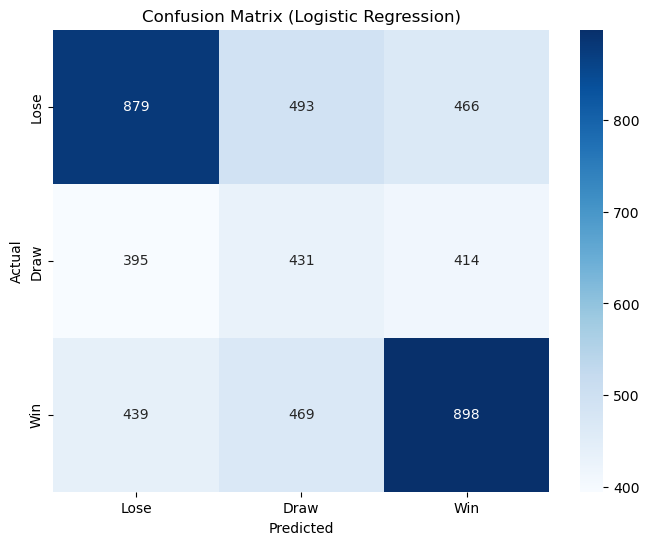

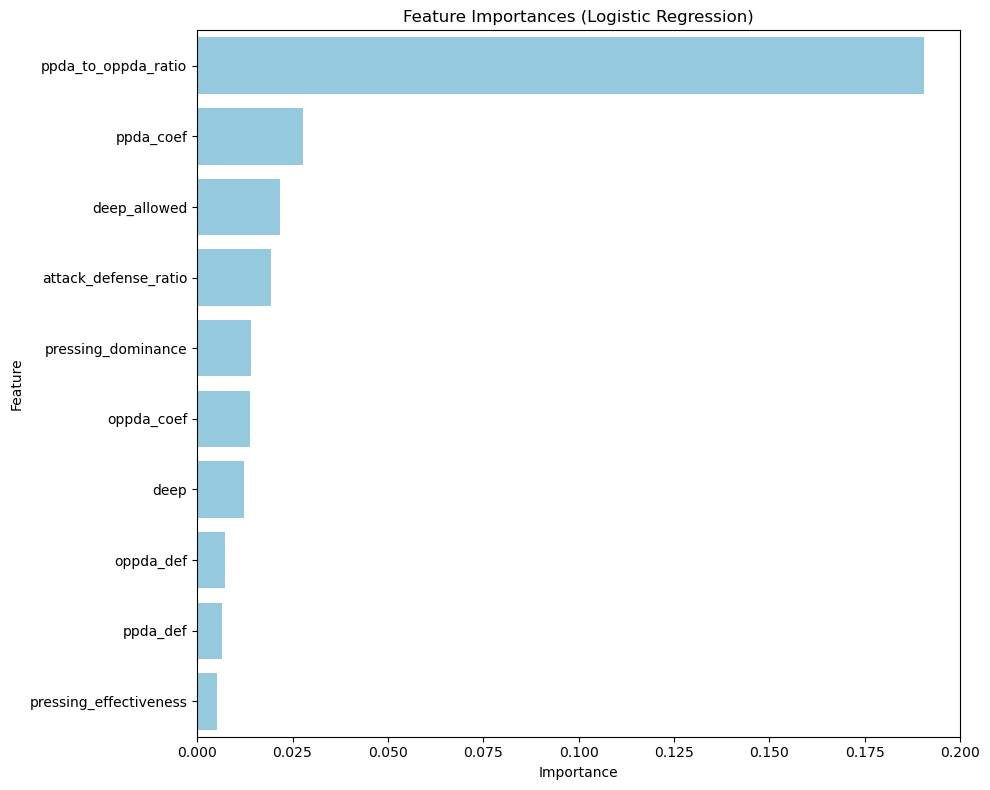


Feature Importances:
                   Feature  Importance
12     ppda_to_oppda_ratio    0.190536
0                ppda_coef    0.027769
3             deep_allowed    0.021593
10    attack_defense_ratio    0.019382
11      pressing_dominance    0.014123
1               oppda_coef    0.013781
2                     deep    0.012318
7                oppda_def    0.007397
5                 ppda_def    0.006572
8   pressing_effectiveness    0.005095
6                oppda_att    0.000990
4                 ppda_att    0.000985
9         defensive_impact    0.000890


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
dataset = pd.read_csv('understat_per_game.csv')

# Step 2: Handle outliers in the target variable ('scored') using the IQR method
Q1 = dataset['scored'].quantile(0.25)
Q3 = dataset['scored'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
dataset = dataset[(dataset['scored'] >= lower_bound) & (dataset['scored'] <= upper_bound)]
print(f"Dataset shape after removing outliers: {dataset.shape}")

# Step 3: Define the target variable ('result') and map to numeric values
result_mapping = {'w': 1, 'd': 0, 'l': -1}
dataset['result'] = dataset['result'].map(result_mapping)

# Drop rows with missing or invalid values in the 'result' column
dataset = dataset.dropna(subset=['result'])
print(f"Dataset shape after filtering invalid 'result': {dataset.shape}")

# Step 4: Define the tactical and engineered features
tactical_features = [
    'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 
    'ppda_att', 'ppda_def', 'oppda_att', 'oppda_def'
]

# Feature Engineering
dataset['pressing_effectiveness'] = dataset['ppda_coef'] * dataset['deep']
dataset['defensive_impact'] = dataset['ppda_def'] * dataset['deep_allowed']
dataset['attack_defense_ratio'] = dataset['deep'] / (dataset['deep_allowed'] + 1)
dataset['pressing_dominance'] = dataset['ppda_coef'] - dataset['oppda_coef']
dataset['ppda_to_oppda_ratio'] = dataset['ppda_coef'] / (dataset['oppda_coef'] + 1)

# Combine features
all_features = tactical_features + [
    'pressing_effectiveness', 'defensive_impact', 'attack_defense_ratio', 
    'pressing_dominance', 'ppda_to_oppda_ratio'
]

# Step 5: Define features (X) and target (y)
X = dataset[all_features]  # Use only specified features
y = dataset['result']  # Target variable (win=1, draw=0, lose=-1)

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Train Logistic Regression model
lr_model = LogisticRegression(
    max_iter=5000,
    random_state=42,
    multi_class='multinomial',
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)

# Step 8: Make predictions
y_pred = lr_model.predict(X_test)

# Step 9: Evaluate the Logistic Regression model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot the confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Lose', 'Draw', 'Win'], yticklabels=['Lose', 'Draw', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# Step 10: Feature Importance for Logistic Regression
feature_importance = pd.DataFrame({
    'Feature': X.columns,  # Use column names from the actual feature set X
    'Importance': np.abs(lr_model.coef_).mean(axis=0)  # Average absolute coefficient values across classes
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', color='skyblue')
plt.title('Feature Importances (Logistic Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nFeature Importances:")
print(feature_importance)
